Loading intrinsic population
Loading GW population
Loading EM population (GRB prompt)
Computing GRB PROMPT limiting thresholds
Saturation rates ETT GRB Afterglow: 8888.905881824747
Computing GRB PROMPT limiting thresholds
Computing GRB PROMPT limiting thresholds
Computing GRB PROMPT limiting thresholds


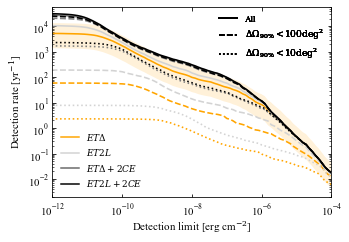

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tabulate import tabulate
import h5py
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u
import scipy
from scipy import stats
from scipy.integrate import cumtrapz
from scipy.ndimage import gaussian_filter as gf
from matplotlib.lines import Line2D
import pandas
import corner
import matplotlib.gridspec as gridspec
import sympy as sp
from functions_ET import * 
import sys
sys.path.insert(0, '../code')
from Prompt_GRB.spectrum import photon_flux
import warnings
warnings.filterwarnings("ignore")

num = 1000000
eos = "SFHo"
mns_max = 2.058882

table = h5py.File('../horizons2/population/computed_population/nsns_%i_%s_GWFAST.hdf5' %(num,eos),'r')

### --- Loading Population --- ###

print("Loading intrinsic population")
m1 = table['m1'][()]
m2 = table['m2'][()]
lamb1 = table['lamb1'][()]
lamb2 = table['lamb2'][()]
z = table['z'][()]
dL = table['dL'][()]
thv = table['thv'][()]
ra = table['ra'][()]
dec = table['dec'][()]
pol = table['pol'][()]
m_dyn = table['m_dyn'][()]
v_dyn = table['v_dyn'][()]
m_disk = table['m_disk'][()]
m_gw = table['m_gw'][()]
E_bkt = table['E_bkt'][()]
E_k_jet = table['E_k_jet'][()]
Ec = table['Ec'][()]
L_sb = table['L_sb'][()]
Eiso_sb = table['Eiso_sb'][()]
Epeak_sb = table['Epeak_sb'][()]
csi_w = 0.05; csi_s = 0.2
m_rem = m1 + m2 - m_gw - m_disk - m_dyn

print("Loading GW population")
snr_ETT = table[('snr_ETT')][()]
snr_ETL = table[('snr_ETL')][()]
snr_ETT2CE = table[('snr_ETT2CE')][()]
snr_ETL2CE = table[('snr_ETL2CE')][()]
sky_loc_ETT = table[('sky_loc_ETT')][()]
sky_loc_ETL = table[('sky_loc_ETL')][()]
sky_loc_ETT2CE = table[('sky_loc_ETT2CE')][()]
sky_loc_ETL2CE = table[('sky_loc_ETL2CE')][()]

print("Loading EM population (GRB prompt)")
bol_fluence_prompt = table['bol_fluence_prompt'][()]
bol_fluence_prompt_tot = table['bol_fluence_prompt_tot'][()]


table.close()

### --- Weights --- ###

#Viewing angle
w_thv = np.sin(thv)

#m1 and m2
w_m1,w_m2 = mass_colombo22(m1,m2)
#w_m1,w_m2 = mass_gauss(m1,m2)

#Redshift z
r0BNS = 347/1.85
r0BNS_high = (347+536)/1.85
r0BNS_low = (347-256)/1.85 

w_z, w_z_high, w_z_low = redshift_weight(z,r0BNS,r0BNS_high,r0BNS_low)

#Total
w = w_m1 * w_m2 * w_z * w_thv
w_high = w_m1 * w_m2 * w_z_high * w_thv
w_low = w_m1 * w_m2 * w_z_low * w_thv

#w =  w_z * w_thv
#w_high = w_z_high * w_thv
#w_low = w_z_low * w_thv

#Monte Carlo normalization
C_mc, C_mc_high, C_mc_low = monte_carlo_normalization(w,w_high,w_low,r0BNS,r0BNS_high,r0BNS_low)

### --- Limiting Thresholds --- ###
lim_snr =12.

lim_prompt = np.logspace(-13,-4,100)
det_fermi = np.zeros(len(lim_prompt))
det_fermi_100 = np.zeros(len(lim_prompt))
det_fermi_10 = np.zeros(len(lim_prompt))
det_fermi = np.zeros(len(lim_prompt))
det_fermi_low = np.zeros(len(lim_prompt))
det_fermi_high = np.zeros(len(lim_prompt))
det_swift = np.zeros(len(lim_prompt))
detfermi = np.zeros(len(lim_prompt))
detswift = np.zeros(len(lim_prompt))
det_fermi_15 = np.zeros(len(lim_prompt))
det_swift_15 = np.zeros(len(lim_prompt))
detfermi_15 = np.zeros(len(lim_prompt))
detswift_15 = np.zeros(len(lim_prompt))

x = np.sort(z)
s = np.argsort(z)

#recomp_gaussian = False
#recomp_uniform = False
plt.rcParams['font.family']="Times New Roman"
#plt.rcParams['font.size'] = 11
plt.rcParams['figure.figsize']=5., 3.5
#plt.rcParams['figure.autolayout']=True
plt.rcParams['mathtext.fontset']='dejavuserif'
#plt.rcParams["axes.axisbelow"] = False 

snr = [snr_ETT, snr_ETL, snr_ETT2CE, snr_ETL2CE]
sky = [sky_loc_ETT, sky_loc_ETL, sky_loc_ETT2CE, sky_loc_ETL2CE]
color_fermi = ['orange','lightgrey','grey','black']


for k in range(0,len(snr)):
    gw_snr = snr[k]
    sky_loc = sky[k]
    
    gw_det = gw_snr >= lim_snr
    
#GRB PROMPT
    print("Computing GRB PROMPT limiting thresholds")
    for i in range(len(lim_prompt)):
        prompt_det_fermi = bol_fluence_prompt_tot >= lim_prompt[i]
        #prompt_det_swift = flux_prompt[:,1] >= lim_prompt[i] 
        cum_gw_fermi = C_mc*np.cumsum(w[s]*prompt_det_fermi[s]*gw_det[s]*(m_rem[s]>1.2*mns_max))
        cum_gw_fermi_100 = C_mc*np.cumsum(w[s]*prompt_det_fermi[s]*gw_det[s]*(sky_loc[s]<100.)*(m_rem[s]>1.2*mns_max))
        cum_gw_fermi_10 = C_mc*np.cumsum(w[s]*prompt_det_fermi[s]*gw_det[s]*(sky_loc[s]<10.)*(m_rem[s]>1.2*mns_max))
        #cum_gw_swift = C_mc*np.cumsum(w[s]*prompt_det_swift[s]*gw_det[s]*(m_rem[s]>1.2*mns_max))
        cum_gw_fermi_low = C_mc_low*np.cumsum(w_low[s]*prompt_det_fermi[s]*gw_det[s]*(m_rem[s]>1.2*mns_max))
        cum_gw_fermi_high = C_mc_high*np.cumsum(w_high[s]*prompt_det_fermi[s]*gw_det[s]*(m_rem[s]>1.2*mns_max))
        det_fermi[i] = cum_gw_fermi[-1]
        det_fermi_100[i] = cum_gw_fermi_100[-1]
        det_fermi_10[i] = cum_gw_fermi_10[-1]
        det_fermi_low[i] = cum_gw_fermi_low[-1]
        det_fermi_high [i] = cum_gw_fermi_high [-1]
        #det_swift[i] = cum_gw_swift[-1] 
        
    plt.plot(lim_prompt,det_fermi*0.6,ls='-',c=color_fermi[k],linewidth=1.6)
    plt.plot(lim_prompt,det_fermi_100*0.6,ls='--',c=color_fermi[k],linewidth=1.6)
    plt.plot(lim_prompt,det_fermi_10*0.6,ls=':',c=color_fermi[k],linewidth=1.6)
    
    leg1=plt.legend([Line2D([0],[0],color='black'),Line2D([0],[0],color='black',ls="--"),Line2D([0],[0],color='black',ls=":")],["All",r"$\Delta\Omega_{{\rm 90}\%}<100\mathrm{deg}^2$",r"$\Delta\Omega_{{\rm 90}\%}<10\mathrm{deg}^2$"],loc=1,prop={'size': 9},frameon=False)
    plt.gca().add_artist(leg1)
    plt.ylabel(r'Detection rate [yr$^{-1}$]',size=11)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim((1.e-12,1.e-4))
    plt.ylim((2.e-3,6.e4))
    if k == 0:
        plt.fill_between(lim_prompt,det_fermi_high*0.6,det_fermi_low*0.6,color='orange',alpha=0.15,edgecolor="None")
        plt.ylabel(r'Detection rate [yr$^{-1}$]',size=11)
        print ("Saturation rates ETT GRB Afterglow:", det_fermi[0])
        leg1=plt.legend([Line2D([0],[0],color='black'),Line2D([0],[0],color='black',ls="--"),Line2D([0],[0],color='black',ls=":")],["All",r"$\Delta\Omega_{{\rm 90}\%}<100\mathrm{deg}^2$",r"$\Delta\Omega_{{\rm 90}\%}<10\mathrm{deg}^2$"],loc=1,prop={'size': 9},frameon=False)
        plt.gca().add_artist(leg1)
        leg2=plt.legend([Line2D([0],[0],color='orange'),Line2D([0],[0],color='lightgrey'),Line2D([0],[0],color='dimgrey'),Line2D([0],[0],color='black')],[r"$ET \Delta$",r"$ET2L$",r"$ET \Delta+2CE$",r"$ET2L+2CE$"],loc=3,prop={'size': 9},frameon=False)
        plt.gca().add_artist(leg2)
        plt.tick_params(which='both',direction='in',left=True,bottom=True,top=True,right=True,labelsize=11)
        plt.xlabel(r'Detection limit [erg cm$^{-2}$]',size=11,labelpad=1) #np.savetxt("nsns_promptETT_colombo.txt",np.vstack([lim_prompt,det_fermi,det_fermi_high,det_fermi_low,det_fermi_100,det_fermi_10]).transpose())
        
    #if k == 1:
        #plt.yticks(color='w',size=1.)
        #print ("Saturation rates ETL GRB Afterglow:", det_fermi[0])
        #np.savetxt("nsns_promptETL_colombo.txt",np.vstack([lim_prompt,det_fermi,det_fermi_high,det_fermi_low,det_fermi_100,det_fermi_10]).transpose())

plt.show()
